!conda activate ddp
!pip install -q -U einops datasets matplotlib tqdm
!pip install datasets

References
==========

https://huggingface.co/blog/annotated-diffusion
https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

In [1]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

/home/mtman/miniconda3/envs/ddpm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Network Helpers
def exists(x):
    return x is not None

def default(val,d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def num_to_groups(num, divisor):
    ## Calcs for group normalization
    groups = num // divisor
    remainder = num % divisor
    arr=[divisor]*groups
    if remainder>0:
        arr.append(remainder)
    return arr

class Residual(nn.Module):
    def __init__(self,fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x,*args,**kwargs) + x
    
def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),nn.Conv2d(dim, default(dim_out,dim),3,padding=1)        
    )

def Downsample(dim, dim_out=None):
    # Assumes image was scaled up with Upsample. Rearrange by splitting out original images and organizing along channel dimension. Then apply 1d convolution. 
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )  
    



In [3]:
# Positional embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    # https://arxiv.org/pdf/1706.03762.pdf Numerically stable way to calcuate the sinusoidal position embedding. The motivation for this choice appears to be thinking of the position as projecting the 1-D position value 
    # into the same dimension space as the model where dimension i corresponds to a frequency component wiht angular frequency of 2*pi*(10000)^(i/(dim/2)) which ranges from 2*pi to 10000*2pi whcih can be thought of as fourier components.
    # The authors acknowlege this is arbitrary but argue for it on the basis of this projected co-ordinate system would allow relative positions PE_{pos+k} to be calculated as a linear function of the encoding of PE_{pos+k}


    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings) #  exp{log (10^-5)^(i/(dim/2))}
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)  #will be of length dim
        return embeddings

In [4]:
# Resnet block: The original paper uses wide resnet blocks but another experimenter replaced the convolution layer with a weighted standardized version which apparently works better with 
# group normalization https://arxiv.org/abs/1912.11370. Perhaps this is because in group norm we take subsets of channels and perform the operations in parallel. If the states of the groups of channels of G,H,W are different then it 
# 

class WeightedStandardizedConv2d(nn.Conv2d):

    def forward(self,x):
        eps = 1e-5 if x.dtype==torch.float32 else 1e-3
        
        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean") # mean over each of the RGB channels. Keep dims
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False)) # var over each of the RGB chanells. Keep dims
        normalized_weight = (weight - mean) * (var + eps).rsqrt() # rsqrt (reciprocal sqrt ... really :) ) 

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

In [5]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightedStandardizedConv2d(dim,dim_out,3, padding=1)  #
        self.norm=nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()
    
    def forward(self, x, scale_shift=None):
        x=self.proj(x)
        x=self.norm(x)
        if exists(scale_shift):
            #scale and shift terms come from the fourier transform interpretation of the sinusoidal position embedding. F(w) = \int_-inf^inf f(t).exp(-iwt)dt. let f(t)->f(t-\del t) => exp(-iw\del t)F(W) phase shift.
            scale, shift = scale_shift
            x=x*(scale+1)+shift
        x=self.act(x)
        return x


In [6]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp=nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out*2)) if exists(time_emb_dim) else None

        self.block1=Block(dim, dim_out, groups=groups)
        self.block2=Block(dim_out,dim_out,groups=groups)
        self.res_conv=nn.Conv2d(dim, dim_out,1) if dim!=dim_out else nn.Identity() # Either skip connection if input and output dimensions are the same otherwise a 1x1 convolution

    def forward(self,x, time_emb=None):
        scale_shift= None
        if exists(self.mlp) and exists(time_emb):
            time_emb=self.mlp(time_emb)
            time_emb=rearrange(time_emb, "b c -> b c 1 1")
            scale_shift=time_emb.chunk(2,dim=1)   # (sin , cos) of time encoding
        h=self.block1(x,scale_shift=scale_shift)
        h=self.block2(h)
        return h+self.res_conv(x)

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False) # 1x1 convolution used to create random projections for Q K and V from the input image.
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self,x):
        # Attention is applied between convolution layers in the Unet arch. Each channel is the results of different convolution filters so can be thought of different embeddings of the visual tokens. 
        # In Multihead attention each head represents a different 'reference plane' whcih in the NLP context represent different embedding subspaces and it is hoped that each captures different aspects of the semantics. 
        # By analoge, multihead attention in image context, each channel the projection of the image onto a different subspace (via convolution filters) with the hope that each captures different semantics. The variation is that
        # in NLP each head deals with a sequence of token embeddings, in the current paradigm for handling images each channel corresponds to one token and output convolution is the embedding of that token. 
        # 
        b, c, h, w = x.shape
        qkv=self.to_qkv(x).chunk(3,dim=1)   # split the composite qkv created from the random projections ( 1x1 convolutions) . Returns list of 3 tensors.
        q,k,v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)',h=self.heads),qkv) #split out q k v for each head h, and unroll the 2d projections of the image 

        q=q*self.scale
        # sim = einsum('b h d i, b h d j -> b h i j', q, k) # inner product along the channel dimension gives the i,j-th 'pixel' similarity across 
        sim = einsum('b h i e, b h j e -> b h i j', q, k) # inner product along the channel dimension gives the i,j-th 'pixel' similarity across 
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn=sim.softmax(dim=-1)

        out = einsum("b h i j, b h j d -> b h i d", attn, v) # this was wrong in the blog. 
        out = rearrange(out, "b h d (x y) -> b (h d) x y", x=h, y=w)
        return self.to_out(out)
    
class LinearAttention(nn.Module):
    '''https://arxiv.org/ftp/arxiv/papers/2007/2007.14902.pdf
        Linear attention idea development starts with characterising the softmax matmult of QK with V as a specific instance of kernel operation. The choose first order taylor series approximatino to the softmax to get a linear attention mechanism
        that is computationally more efficient.

    '''
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [8]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        # Groupnorm with 1 group is layer norm
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [9]:
'''
    Conditional Unet.
'''
class Unet(nn.Module):
    def __init__(
            self,
            dim,
            init_dim=None,
            out_dim=None,
            dim_mults=(1,2,4,8),
            channels=3,
            self_condition=False,
            resnet_block_groups=4
    ):
        super().__init__()

        self.channels = channels # starts at RGB
        self.self_condition = self_condition
        input_channels = channels* (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1 , padding =0) # first layer of Unet. Number of filters ( init_dim) 
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # init_dim defaults to dim if no value passed in. 
        in_out = list(zip(dims[:-1], dims[1:])) # the input to output dimension changes for downsample, upsample

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)  # resnet_block_groups is for group norm in resnetblock. Values used are 4 and 8. Note this works in conjunction with normalised weight conv2d

        # The FCN in transformer block do a 4 x dim expansion and then a projection. This is applying the same operation to time embedding. 
        time_dim = dim*4 
        self.time_mlp = nn.Sequential(SinusoidalPositionEmbeddings(dim),
                                      nn.Linear(dim, time_dim),
                                      nn.GELU(),
                                      nn.Linear(time_dim, time_dim),)
        
        self.downs=nn.ModuleList([]) # registers all modules in list for __all__
        self.ups=nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind>=(num_resolutions-1)
            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out)
                if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding =1),
            ]))
        
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone() 

        t = self.time_mlp(time)  # time is passed through 2 MLP's and not sure why? 

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


In [10]:
from PIL import Image
pic = './img_align_celeba/img_align_celeba/000001.jpg'
image = Image.open(pic)

from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'

image = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC


In [11]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into torch Tensor of shape CHW, divide by 255
    Lambda(lambda t: (t * 2) - 1), # shift to [-1,1] to make the values centered around zero to align with the initial noise sample for the reverse process which is drawn from a std normal
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

In [12]:
unet = Unet(dim=image_size,channels =3, dim_mults=(1,2,4,))
unet

Unet(
  (init_conv): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (block1): Block(
          (proj): WeightedStandardizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 128, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightedStandardizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 128, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): 

In [13]:
def _reset_all_params(model: nn.Module):
    for layer in model.children():
        if hasattr(layer,'reset_parameters'):
            layer.reset_parameters()

In [14]:
x_start.shape
time=torch.tensor([40])
im_list = []
for i in range(6):
    a=unet(x_start, time) #scaled, shifted tensor version of PIL image.
    _reset_all_params(unet)
    im_list.append(a)
len(im_list)

6

In [15]:
import numpy as np
reverse_transform = Compose([
    Lambda(lambda t: (t+1)/2),
    Lambda(lambda t: t.permute(1,2,0)), #CHW to HWC
    Lambda(lambda t: t*255.)
    ,Lambda(lambda t:t.numpy().astype(np.uint8)),  # Automaticallly clips it to 255
    ToPILImage(),
])



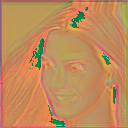

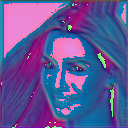

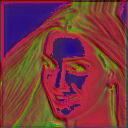

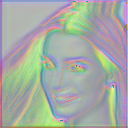

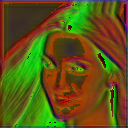

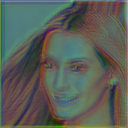

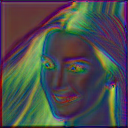

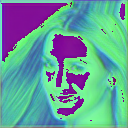

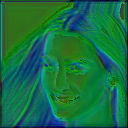

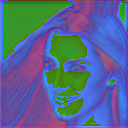

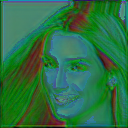

In [16]:
from PIL import ImageChops

reversed_list=[]
for im in im_list:
    reversed_list.append(reverse_transform(im.squeeze().detach())) # reverse to get PIL image
    reversed_list[-1].show()
    if len(reversed_list)>1:
        ImageChops.difference(reversed_list[-1],reversed_list[-2]).show()

In [17]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [18]:
# helpers to deal with time step
timesteps=200 # T=300 for fashion mnist

#create linear schedule of betas for this demo.
betas = linear_beta_schedule(timesteps=timesteps)

alphas = 1. - betas
alphas_cumprod=torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0) #prepend a 1. to the shifted list of cumprod alphas
sqrt_recip_alphas = torch.sqrt(1.0/alphas)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod=torch.sqrt(1. - alphas_cumprod)  # see equation (11) is paper. $$ \mu_{\theta}(x_t,t) = {1 \over \sqrt{\alpha_{t}}}\left(x_t - {\beta_t \over \sqrt{1-\bar{\alpha_t}}} \epsilon_\theta(x_t, t)\right)$$

posterior_variance = betas * (1. - alphas_cumprod_prev)/(1. - alphas_cumprod)

def extract(a,t,x_shape):
    '''Index into the alpha's, betas etc (a) and shape it to be able to apply it pixelwise to the image tensor.
    a = cummulative alphas, beta etc.
    t = time index into a.
    x_shape : shape of input tensor (b) x ....   
    '''
    batch_size=t.shape[0]
    out=a.gather(-1,t.cpu())
    return out.reshape(batch_size, *((1,)*(len(x_shape)-1))).to(t.device)


In [20]:
# Finally, forward diffusion as per paper
def q_sample(x_start: torch.tensor, t: float, noise=None):
    if noise is None:
        noise=torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t*x_start + sqrt_one_minus_alphas_cumprod_t* noise  # see the simplified training objective for the noise


In [21]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

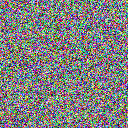

(None, (128, 128))

In [22]:
t = torch.tensor([199])

a= get_noisy_image(x_start, t)
a.show(), a.size

for i in range(0,900,100):
    x_noisey=q_sample(x_start,torch.tensor([i]))
    print(torch.mean(x_noisey), torch.var(x_noisey))

# looks like it takes nearly 1000 steps to get close to normal 

In [23]:
import matplotlib.pyplot as plt
torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(128,128), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

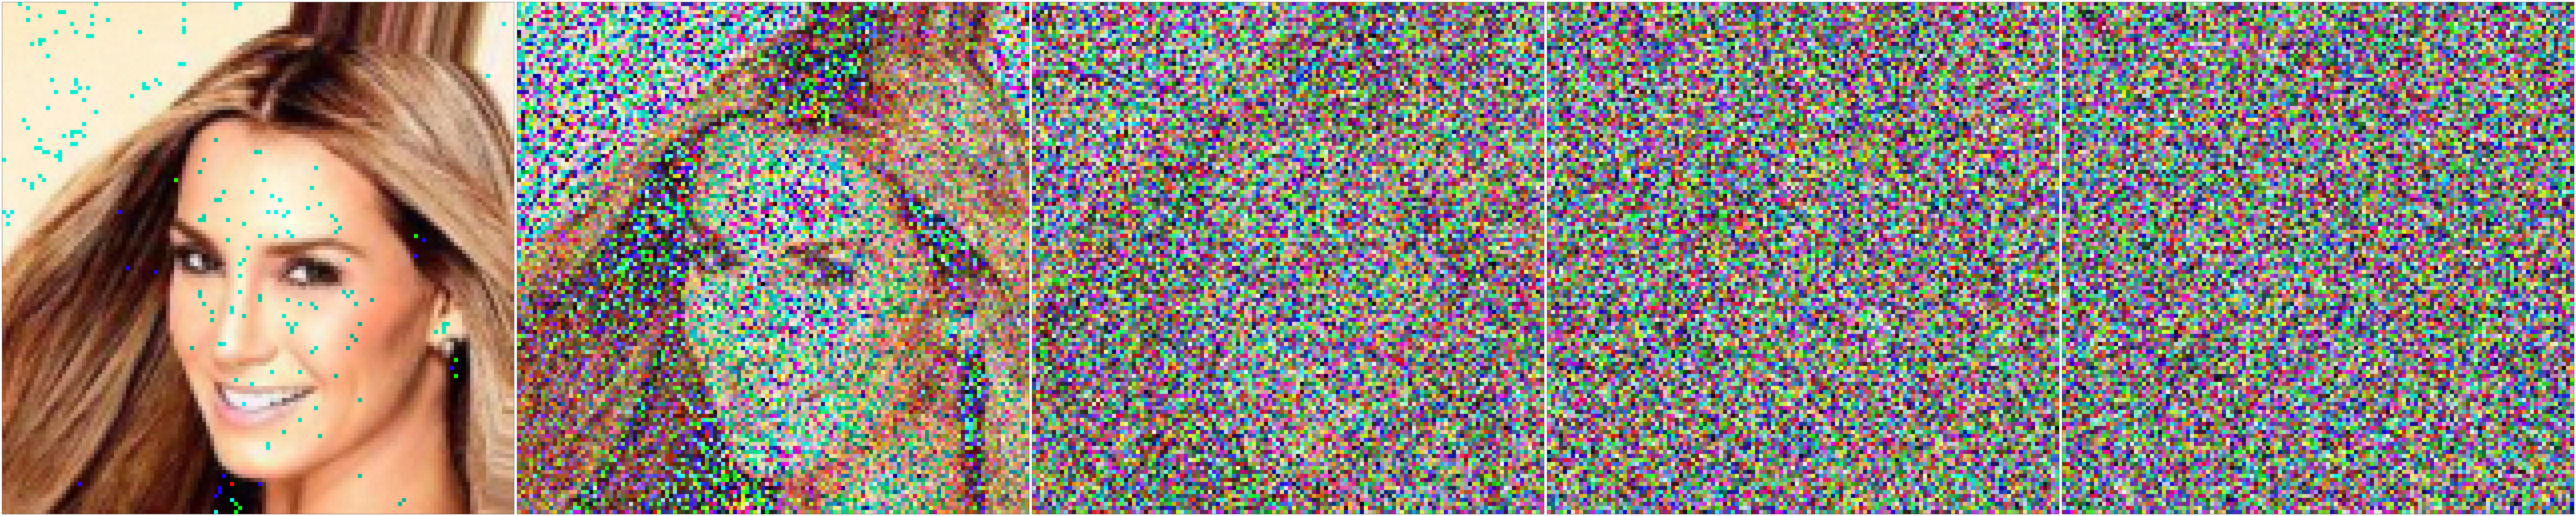

In [24]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [25]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)  # The beauty of the diffusion model is that the forward diffusion process has a closed form expression. 
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset

dataset=load_dataset('fashion_mnist')

image_size=28
channels=1
batch_size=128

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])



# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

image_scaled = next(iter(dataloader))
mini_batch = [reverse_transform(image_scaled[0][i]) for i in range(10)]
plot(mini_batch)

In [26]:
def p_sample(model,x,t,t_index):
    betas_t=extract(betas,t, x.shape) #betas to be applied pielwise

    sqrt_one_minus_alphas_cumprod_t=extract(sqrt_recip_alphas,t,x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


In [37]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    '''Reverse process
    returns: Tensor
    '''
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise  # x_{t-1}

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        #imgs.append(img.cpu().numpy())
        imgs.append(img.cpu())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    '''
    model: denoising model
    images_size: int: images assumed square, pixel length of side.
    batch: number of samples to propogate back through the diffusion process.
    @returns:
    list of batches of tensors: '''
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [38]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 10000

In [39]:
# Celeba dataloader

image_root_dir='./img_align_celeba/img_align_celeba/'
image_file_list ='./img_align_celeba_file.csv'

import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader

image_size=128
channels=3
batch_size=24

class CelebDataSet(Dataset):
    def __init__(self,image_list, image_root_path, transform=None):

        self.image_list = pd.read_csv(image_file_list,names=['filename'])
        print(self.image_list.shape)
        self.image_files = self.image_list['filename'].apply(lambda x: os.path.normpath(image_root_path+os.sep+f'{x}'))
        self.transforms = transform

    def __len__(self):
        return self.image_list.shape[0] # includes corrupted images
    
    def __getitem__(self, idx):
        if idx>=len(self.image_list):
            raise RuntimeError('image index out of range')
        ret=None
        try:
            img = Image.open(self.image_files[idx])
            if self.transforms:
                ret = self.transforms(img)
            else:
                raise RuntimeError('PILimages must be transformed into tensors and pixel values rescaled to range [-1,1]')
        except Exception as e:
            print(f'error reading image with index {idx}')
            print(f'{e}')
        return ret, idx

# define image transformations (e.g. using torchvision)
from torchvision.transforms import transforms

transform = Compose([Resize(image_size),
            CenterCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),   # scales by 255
            transforms.Lambda(lambda t: (t * 2) - 1)
])

dataset = CelebDataSet(image_file_list,image_root_path=image_root_dir, transform=transform)
dataloader=DataLoader(dataset,batch_size=batch_size, shuffle=True)

(202599, 1)


In [40]:
import numpy as np
tensor_to_PIL = Compose([
    Lambda(lambda t: (t+1)/2),
    Lambda(lambda t: t.permute(1,2,0)), #CHW to HWC
    Lambda(lambda t: t*255.)
    ,Lambda(lambda t:t.numpy().astype(np.uint8)),  # Automaticallly clips it to 255
    ToPILImage(),
])

In [41]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4, 8)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=2e-4)

In [42]:
#setup wandb
import wandb
from uuid import uuid4
import os

In [43]:
wandb.login(host='http://localhost:8080', key='local-c6445bd877c8f3cec4f5abdaa31e4266d042408e')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [44]:
#wandb.login()
hash = str(uuid4())[:7]

run=wandb.init(
                project=f'ddpm-caleba',
                name=f'run-{hash}',
                config={
                    'timesteps':timesteps,
                    'lr':optimizer.param_groups[0]['lr']
               })

checkpoint_path = f'./checkpoints/{hash}'
os.makedirs(checkpoint_path, exist_ok=False)

loss,▁
loss,0.44607


In [45]:
def show_sample(model, image_size, batch_size=32):
    samples = sample(model, image_size=image_size, batch_size=batch_size, channels=3)
    # show a random one
    random_index = 2
    a=tensor_to_PIL(samples[-1][-1,:,:,:].squeeze()) # convert to PILImage
    a.show()

Epoch 0


DDPM training loop:   0%|          | 0/8442 [00:00<?, ?it/s]

Epoch:0, batch#:0, Loss:0.44607406854629517


sampling loop time step: 100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


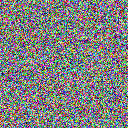

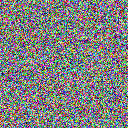

In [ ]:
from torchvision.utils import save_image
from itertools import chain

epochs = 6
model.train()

for epoch in range(epochs):
    print (f'Epoch {epoch}')
    for step, batch in enumerate(tqdm(dataloader, desc='DDPM training loop')):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")
  
      loss.backward()
      optimizer.step()
      if step % 100 == 0:
        print(f"Epoch:{epoch}, batch#:{step}, Loss:{loss.item()}")
        wandb.log({'loss':loss})
      if step %100 ==0:
         show_sample(model,image_size,16)

    # save generated images
    #if step != 0 and step % save_and_sample_every == 0:
    #if step % save_and_sample_every == 0:
    #export some samples
    batches = num_to_groups(4, batch_size)
    all_images_list = list(map(lambda n: sample(model, image_size=image_size, batch_size=n, channels=channels), batches))
    # flatten the map nested lists
    all_images_list = list(chain.from_iterable(all_images_list))
    all_images = torch.cat(all_images_list, dim=0)
    all_images = (all_images + 1) * 0.5
    save_image(all_images, str(results_folder / f'sample-{epoch}.png'), nrow = 6)
    
    torch.save({'epoch':epoch,
          'model_state_dict':model.state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'loss':loss}, f'./checkpoints/celeba-model-{epoch}.pt')

wandb.finish()

In [ ]:
checkpoint = torch.load('./checkpoints/celeba-model-0.pt')

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
show_sample(model, image_size)

In [ ]:
import matplotlib.animation as animation

random_index = 2

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()